# Using Different History Summarization Modules


- In this Tutorial, we will cover basic history summarization modules in reinforcement learning with partially observable state representations.
- In doing so, we also illustrate how to create a partially observable MDP given an existing fully-observable gym environment.

# Import Modules

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.replay_buffers import BasicReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

# Instantiate a partially observable environment by using the CartpolePartialObservableWrapper class!

In [ ]:
import gymnasium as gym
raw_env = gym.make("CartPole-v1")
from pearl.user_envs.wrappers.partial_observability import (
    CartPolePartialObservableWrapper,
)

env = CartPolePartialObservableWrapper(raw_env, time_between_two_valid_obs=1)
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
env = GymEnvironment(env)


# Create 3 DQN agents each with different history summarization approaches

We will try vanilla DQN (no state summarization), framestacking which hardcodes the state by stacking the last few frames, and LSTM which learns the state automatically from the agent's experience.

In [ ]:
from pearl.history_summarization_modules.lstm_history_summarization_module import (
    LSTMHistorySummarizationModule,
)

from pearl.history_summarization_modules.stacking_history_summarization_module import (
    StackingHistorySummarizationModule,
)


def create_agent(
    env,
    hidden_dims,
    mode: str = "vanilla",                 # "vanilla" | "lstm" | "framestack"
    history_length: int = 10,              # required for lstm/framestack
    lstm_hidden_dim: int = 32,             # state_dim used by LSTM summarizer → policy
    training_rounds: int = 50,
    buffer_size: int = 100_000,
):
    """
    Create a PearlAgent configured as:
      - mode="vanilla":     no history summarization; state_dim = obs_dim
      - mode="lstm":        LSTMHistorySummarizationModule; state_dim = lstm_hidden_dim
      - mode="framestack":  StackingHistorySummarizationModule; state_dim = history_length * (obs_dim + num_actions)

    Args:
        env: Gymnasium-like env with .observation_space, .action_space (discrete).
        hidden_dims: list/tuple of MLP layer sizes for the Q-network.
        mode: "vanilla" | "lstm" | "framestack".
        history_length: window length for history-based modes
        lstm_hidden_dim: hidden/state size of the LSTM summarizer (also used as policy state_dim).
        training_rounds: DeepQLearning training_rounds.
        buffer_size: replay buffer capacity.

    Returns:
        PearlAgent
    """
    num_actions = env.action_space.n
    obs_dim = env.observation_space.shape[0]

    history_module = None
    if mode == "vanilla":
        state_dim = obs_dim

    elif mode == "lstm":
        state_dim = lstm_hidden_dim
        history_module = LSTMHistorySummarizationModule(
            observation_dim=obs_dim,
            action_dim=num_actions,
            hidden_dim=lstm_hidden_dim,
            history_length=history_length,
        )

    elif mode == "framestack":
        state_dim = history_length * (obs_dim + num_actions)
        history_module = StackingHistorySummarizationModule(
            observation_dim=obs_dim,
            action_dim=num_actions,
            history_length=history_length,
        )
    else:
        raise ValueError(f"Unknown mode '{mode}'. Use 'vanilla', 'lstm', or 'framestack'.")

    policy = DeepQLearning(
        state_dim=state_dim,
        action_space=env.action_space,
        hidden_dims=hidden_dims,
        training_rounds=training_rounds,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    )

    agent_kwargs = dict(
        policy_learner=policy,
        replay_buffer=BasicReplayBuffer(buffer_size),
    )
    if history_module is not None:
        agent_kwargs["history_summarization_module"] = history_module

    return PearlAgent(**agent_kwargs)

In [ ]:
results = {}

for label in ["vanilla", "framestack", "lstm"]:
    agent = create_agent(env, hidden_dims = [64, 64], mode = label)
    set_seed(0)
    # Create unique filename for each agent
    filename = f"DQN-return-{label}.pt"
    print(f"Training {label}")
    info = online_learning(
        agent=agent,
        env=env,
        number_of_episodes=50,
        print_every_x_episodes=5,
        learn_after_episode=True,
        seed=0)

    torch.save(info["return"], filename)
    results[label] = info["return"]

Training vanilla
episode 5, step 48, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 8.0
episode 10, step 118, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 33.0
episode 15, step 305, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 40.0
episode 20, step 383, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 11.0
episode 25, step 578, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 44.0
episode 30, step 824, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 56.0
episode 35, step 1039, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 47.0
episode 40, step 1260, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 30.0
episode 45, step 1462, agent=PearlAgent with DeepQLearning, BasicReplayBuffer, env=CartPole-v1
return: 28.0
episode 50, step 165

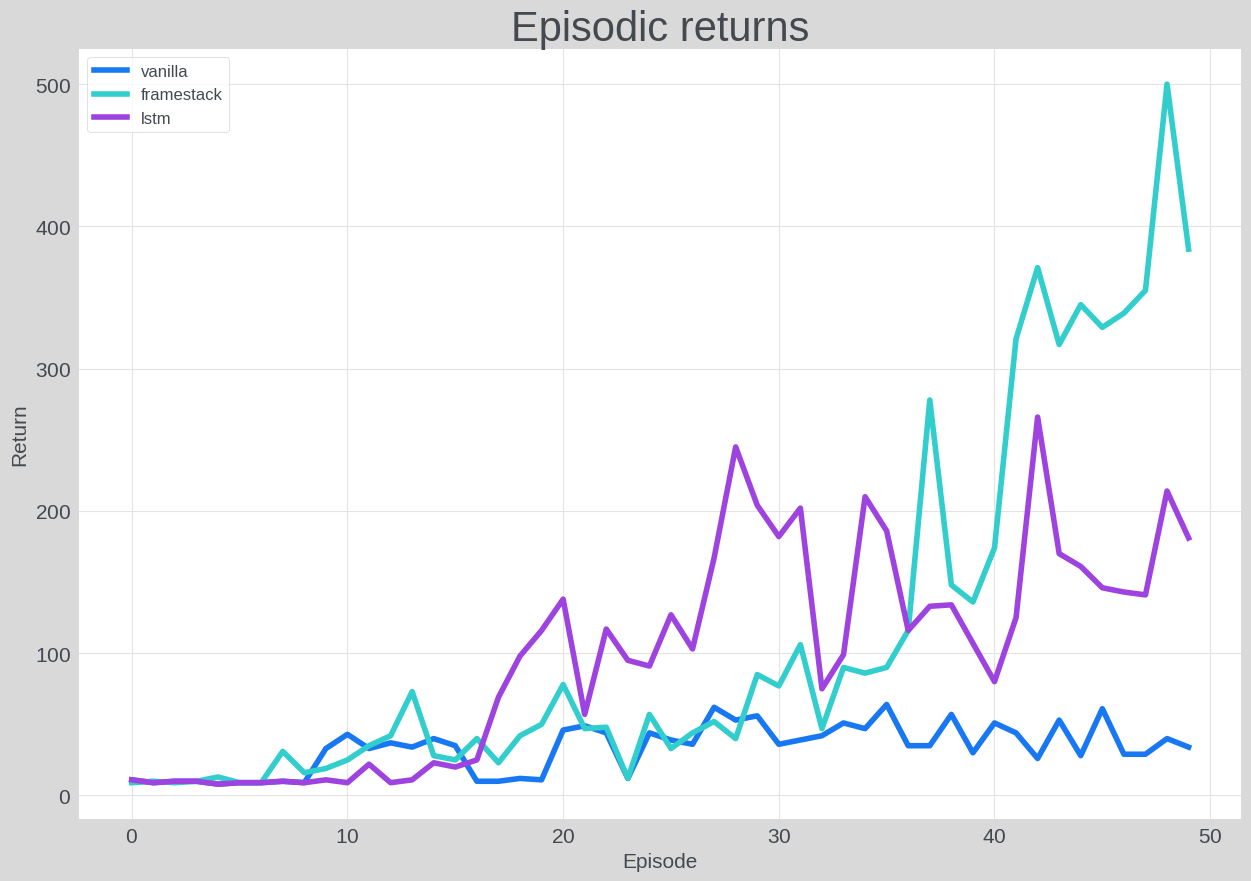

In [ ]:
# Plot all results
for label, returns in results.items():
    plt.plot(np.arange(len(returns)), returns, label=label)

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()